# Problem 1

Best viewed at <https://github.com/rafoss/ml-assignments/blob/master/assignment1/main.ipynb>

The dataset is available for download at <https://www.kaggle.com/datasets/zaheenhamidani/ultimate-spotify-tracks-db>

## (1a)

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

dataset_raw = pd.read_csv('SpotifyFeatures.csv')
print("The dataset contains {0} songs with {1} features".format(*dataset_raw.shape))

The dataset contains 232725 songs with 18 features


## (1b)

In [159]:
# Extract only liveness and loudness from the dataset, and convert classical & pop genres to 0's & 1's
filter_genres = ['Classical', 'Pop']
filter_features = ['liveness', 'loudness']
dataset_filtered = dataset_raw[dataset_raw['genre'].isin(filter_genres)]
dataset = pd.concat([
    dataset_filtered['genre'].map(filter_genres.index),
    dataset_filtered[filter_features]
], axis=1)
dataset

,genre,liveness,loudness
104022,0,0.0762,-21.356
104023,0,0.1060,-34.255
104024,0,0.0916,-28.215
104025,0,0.1730,-37.264
104026,0,0.0858,-35.213
...,...,...,...
167297,0,0.0776,-25.477
167298,0,0.2450,-28.192
167299,0,0.0816,-25.843
167300,0,0.1050,-20.238


## (1c)

In [160]:
# Randomly sample 80% from each genre, portioning the dataset into 80% training, 20% validation
training_dataset = dataset.groupby('genre').sample(frac=0.8)
validation_dataset = dataset.drop(training_dataset.index)

# Convert the dataframes into numpy arrays
training_features = np.array(training_dataset.iloc[:, 1:])
training_labels = np.array(training_dataset.iloc[:, 0:1])
validation_features = np.array(validation_dataset.iloc[:, 1:])
validation_labels = np.array(validation_dataset.iloc[:, 0:1])

training_dataset, validation_dataset

(        genre  liveness  loudness
 104945      0    0.0638   -36.886
 123676      0    0.2420   -17.092
 104896      0    0.0826   -31.049
 105156      0    0.0588   -32.450
 123779      0    0.3790   -38.619
 ...       ...       ...       ...
 150533      1    0.2850    -5.138
 150026      1    0.0849    -4.128
 150644      1    0.1180    -7.322
 151339      1    0.2870    -5.436
 112087      1    0.3830    -6.852
 
 [14914 rows x 3 columns],
         genre  liveness  loudness
 104029      0    0.1060   -30.699
 104034      0    0.0940   -26.250
 104040      0    0.0972   -26.801
 104042      0    0.1200   -26.487
 104045      0    0.0702   -30.033
 ...       ...       ...       ...
 167277      0    0.1550   -12.774
 167294      0    0.0621    -3.143
 167295      0    0.0731   -19.253
 167296      0    0.0984   -16.461
 167297      0    0.0776   -25.477
 
 [3728 rows x 3 columns])

## (1d)

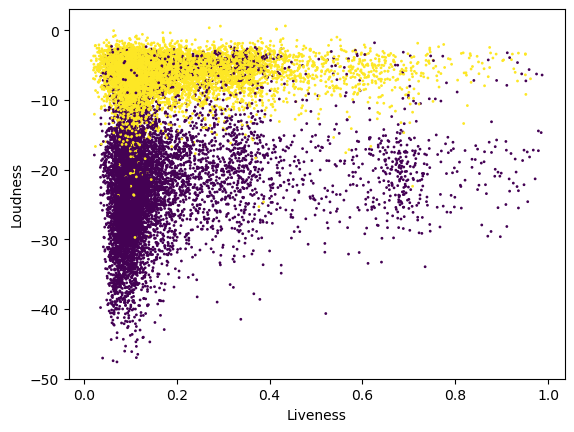

In [161]:
# Plot liveness and loudness in a scatter plot, with color indicating which genre each point belongs to
plt.scatter(
    dataset['liveness'],
    dataset['loudness'],
    c=dataset['genre'],
    s=1
)
plt.xlabel('Liveness')
plt.ylabel('Loudness')
plt.show()

It looks like most classical and pop songs can be easily distinguished based on only liveness and loudness, since they for the most part form separate clusters. There are however several outliers, assuming the dataset is correctly labeled, and some mixing around liveness $= 0.1$.

# Problem 2

## (2a)

Epoch 0: loss=0.25


Epoch 5000: loss=0.0848423787565593
Epoch 10000: loss=0.07293744198393207
Epoch 15000: loss=0.06897344422329003
Epoch 20000: loss=0.06703340589636579
Epoch 25000: loss=0.0658942381319041
Epoch 30000: loss=0.06515002204645894
Epoch 35000: loss=0.06462844832372439
Epoch 40000: loss=0.06424423990714043
Epoch 45000: loss=0.06395049062102708
Epoch 50000: loss=0.06371932332697391
Epoch 55000: loss=0.06353315826417819
Epoch 60000: loss=0.06338037695894433
Epoch 65000: loss=0.06325300283159578
Epoch 70000: loss=0.06314538424667754
Epoch 75000: loss=0.06305340916019334
Epoch 80000: loss=0.06297401715062628
Epoch 85000: loss=0.06290488545787407
Epoch 90000: loss=0.0628442208191341
Epoch 95000: loss=0.06279061779547121
Epoch 100000: loss=0.06274296011171288


Text(0, 0.5, 'Loss')

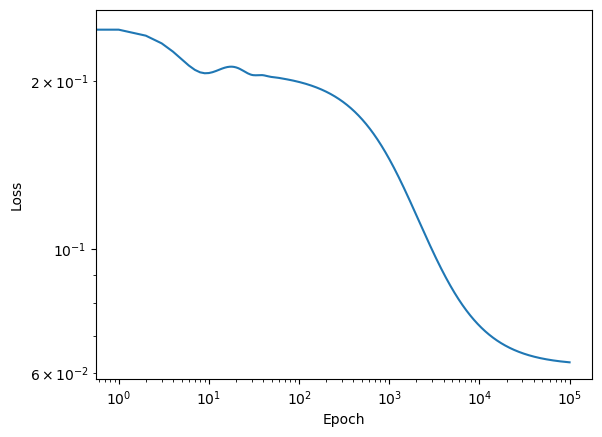

In [162]:
num_epochs = 100001
step_size = 1e-3 # step size in the direction opposite to the gradient
momentum = .9 # keep 90% of the momentum from the previous step, hoping for a faster descent

num_features = training_features.shape[1]
num_training_samples = len(training_labels)

weights = np.zeros((num_features, 1))
biases = np.zeros((1, 1))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

losses = []
prev_weights = weights
prev_biases = biases

for epoch in range(num_epochs):
    # Ideally, we'd use cross-entropy loss, but I was curious about how MSE would perform
    predictions = sigmoid(training_features @ weights + biases)
    error = predictions - training_labels
    loss = np.mean(error ** 2)
    losses.append(loss)

    # TODO: stochastic mini-batching

    # Compute the gradient of the mean squared loss function. By the chain rule, we also need
    # to differentiate the sigmoid function, before finally differentiating with respect to the
    # feature variables or the constant bias. The mean is computed rather than using the sum
    # directly, since hyperparameters shouldn't depend on the number of samples.
    grad = 2 * error * predictions * (1 - predictions)
    grad_weights = 1 / num_training_samples * (training_features.T @ grad)
    grad_biases = 1 / num_training_samples * np.sum(grad)

    if epoch % 5000 == 0:
        print(f"Epoch {epoch}: loss={loss}")

    # In addition to taking a step in the direction opposite to the gradient, an extra small
    # step is taken based on the previous step, to introduce a little bit of momentum to the
    # gradient descent process, in hopes that it can move more quickly past less interesting
    # portions of the multi-dimensional surface
    momentum_weights = momentum * (weights - prev_weights)
    momentum_biases = momentum * (biases - prev_biases)
    prev_weights = np.copy(weights)
    prev_biases = np.copy(biases)

    # Take a small step away from where the gradient is pointing, towards a local minimum,
    # as well as continuing to move a little in the same direction as previously
    weights += -step_size * grad_weights + momentum_weights
    biases += -step_size * grad_biases + momentum_biases

# plot the loss per epoch on a log-log scale with our fingers crossed,
# this should almost always trend downwards, and hopefully begin to converge
plt.plot(range(num_epochs), losses)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')

A larger `step_size` results in fewer epochs spent searching for a steeper decline, but with too large steps it can overshoot and be unable to fall into a smaller pocket. Adding momentum allows larger steps without having to sacrifice finer movements, since the momentum depends on the previous step size and thus the gradient. That said, there's now two knobs to tweak instead of one and tuning these hyper parameters can still be a finicky process.

## (2b)

In [163]:
# Compute the predicted classification (the single neuron's activation) for each sample
# in the validation set and training set respectively. Round the prediction to the nearest
# integer to get a definite genre prediction from the predicted probability, then compare
# this to the corresponding label. If the prediction is incorrect, the absolute value will be 1,
# so sum up all of the 1's to get a tally of incorrect predictions for each dataset.

predictions = sigmoid(validation_features @ weights + biases)
num_incorrect = np.sum(np.abs(np.rint(predictions) - validation_labels))
print(f"The model correctly predicts ~{(1 - num_incorrect / len(validation_labels)) * 100:.1f}% of the samples in the validation dataset")

predictions = sigmoid(training_features @ weights + biases)
num_incorrect = np.sum(np.abs(np.rint(predictions) - training_labels))
print(f"The model correctly predicts ~{(1 - num_incorrect / len(training_labels)) * 100:.1f}% of the samples in the training dataset")

The model correctly predicts ~92.3% of the samples in the validation dataset
The model correctly predicts ~92.8% of the samples in the training dataset


Some difference between the training and validation set prediction accuracy is expected, and since the validation accuracy is roughly on par with the training accuracy, we can be reasonably confident that the model hasn't overfit on the training data. Overfitting with only 3 model parameters is probably unlikely anyway.

## (2c)

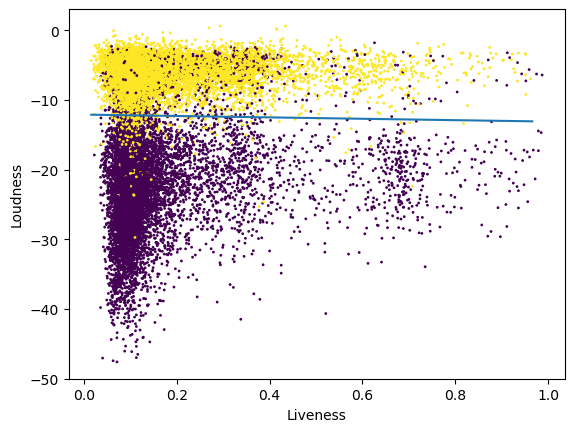

In [164]:
plt.scatter(
    dataset['liveness'],
    dataset['loudness'],
    c=dataset['genre'],
    s=1
)
plt.xlabel('Liveness')
plt.ylabel('Loudness')

# Plot the same scatter plot again, but include what I'll refer to as the "decision boundary"
# as a line in the plot. This line is solved for by solving for one of the feature variables
# when it in combination with another known feature variable produces an output = 0, which
# the sigmoid function remaps to 0.5, which means that the model gives the particular coordinate
# a 50% chance of being either a classical or pop song, i.e. where it is maximally uncertain
x = np.arange(np.min(dataset['liveness']), np.max(dataset['liveness']), .05)
y = (-biases - x * weights[1, 0]) / weights[1, 0]
plt.plot(x, y[0])
plt.show()

The plot above shows the "decision boundary", where the model gives an equal probability for each genre, as a line on top of the loudness vs. liveness plot, showing that the regression has found a fairly decent boundary.

# Problem 3

## (3a)

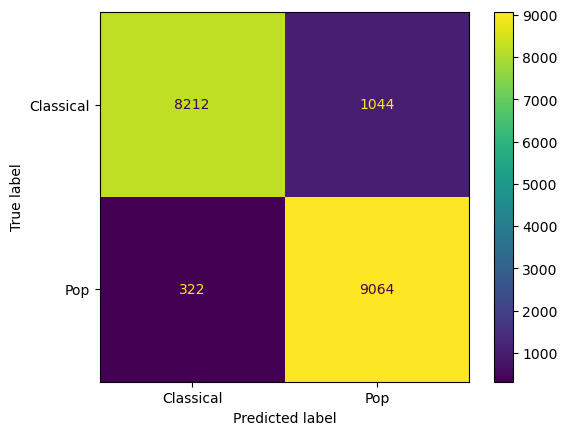

In [165]:
# Construct a confusion matrix based on the predicted and ground truth genres
ground_truths = np.array(dataset['genre'])
raw_predictions = sigmoid(np.array(dataset.iloc[:, 1:]) @ weights + biases)
predictions = np.rint(raw_predictions).astype(np.int32)[:, 0]

confusion_matrix = np.zeros((2, 2), dtype=np.int32)
for truth, prediction in zip(ground_truths, predictions):
    confusion_matrix[truth, prediction] += 1 # slightly neat trick I think

# A question on Discord said it was okay to use sklearn to create the matrix,
# so it should definitely be fine just for displaying it. There didn't seem to
# be any convenient ways of doing it with matplotlib directly.
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix, display_labels=filter_genres)
disp.plot()
plt.show()

The confusion matrix for the complete dataset shows that the model accurately predicts most of the songs correctly, with a small portion of songs incorrectly predicted as classical, and an even smaller portion incorrectly predicted as pop.

## (3b)

The confusion matrix makes it easier to see which genre the model struggles with more. We can see that a larger portion of classical songs are incorrectly predicted to be pop songs than vice versa.

## (3c)

In [166]:
# The idea here is simply to filter the list for songs labelled as classical,
# but predicted to be pop songs by the model, then order them by how strongly
# the model feels the song should be a pop song. Hopefully that yields some
# decent pop-sounding classical song suggestions
max_suggestions = 15
pop_index = filter_genres.index('Pop')
dataset_with_predictions = dataset_filtered.copy()
dataset_with_predictions['predicted_genre'] = predictions
dataset_with_predictions['raw_prediction'] = raw_predictions
dataset_with_predictions = dataset_with_predictions[
    (dataset_with_predictions.genre == 'Classical') &
    (dataset_with_predictions.predicted_genre == pop_index)
]
dataset_with_predictions.sort_values(
    by=['raw_prediction'], ascending=False, inplace=True)
dataset_with_predictions.head(max_suggestions)

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,predicted_genre,raw_prediction
127261,Classical,Richie Kotzen,Go Faster,7qLq9x0er8eP04MIaxwK0Y,43,0.133000,0.504,175773,0.939,0.007580,C,0.6260,-1.786,Minor,0.0554,118.090,4/4,0.741,1,0.991561
130662,Classical,Ancient Bards,Through My Veins,5ZaPLI4eUmxw6l8eQAWTkO,40,0.000079,0.290,439640,0.982,0.000000,G,0.3160,-2.358,Major,0.0841,90.131,4/4,0.366,1,0.987968
124574,Classical,Queensrÿche,Another Rainy Night (Without You) - Remastered...,4tUma2etb9HVEHTeIdJjl3,42,0.091700,0.462,269373,0.955,0.000138,A,0.3690,-2.456,Minor,0.0645,96.930,4/4,0.324,1,0.987665
167266,Classical,Queensrÿche,Resistance - Remastered/2003,7IYKTl0Jhz9T8u4etdq37C,29,0.013500,0.452,290667,0.989,0.000631,A,0.1340,-2.349,Major,0.1670,129.922,4/4,0.200,1,0.987257
129624,Classical,Conquering Dystopia,Ashes of Lesser Men,09F9ERsvgwC4Kel6f9VAX1,29,0.000006,0.440,335282,0.987,0.881000,A,0.0596,-2.304,Major,0.1290,134.984,4/4,0.257,1,0.987188
128731,Classical,Andy James,Obsession,6d3hYluFN9nyRpPdU9EHxC,32,0.000014,0.382,219035,0.955,0.164000,C#,0.3250,-2.544,Minor,0.0673,104.990,4/4,0.295,1,0.986991
105305,Classical,Queensrÿche,I Don't Believe In Love - Remastered 2003,0U2TocFjqul3sis3sE5jZl,53,0.037300,0.562,263560,0.991,0.000011,G,0.4250,-2.654,Major,0.0745,118.004,4/4,0.266,1,0.986804
127708,Classical,Andy James,Afterlife,2YPuZOOm5w7ynLK4hvU1WN,34,0.000200,0.335,252085,0.938,0.458000,D,0.3520,-2.664,Minor,0.0673,145.043,4/4,0.287,1,0.986416
125635,Classical,Queensrÿche,Revolution Calling - Remastered 2003,0GoQdU4T7AwJrrhE1WKFww,40,0.047300,0.571,279827,0.991,0.000037,D,0.2190,-2.569,Major,0.0667,123.954,4/4,0.295,1,0.986370
126771,Classical,Andy James,Equinox,5rkoaupq70zo2EDfg1kpp1,36,0.000073,0.372,228464,0.917,0.005360,A,0.3730,-2.717,Minor,0.0768,129.969,4/4,0.146,1,0.986197


As mentioned in 3b, classical songs are more difficult to classify for this particular model. The table above shows the top 15 classical songs which the model incorrectly classified as pop, ordered by prediction confidence from high to low.